In [35]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_pixel_similarity
from models_src.fft_lib import xy_coords, decode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg
from models_src.DETR import FFN, HeadsPermuter

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
reload_script('models_src.VecModels')

In [2]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/pixel_features_extraction")
mlflow.tensorflow.autolog(log_datasets=False, log_models=True, disable=True )

In [29]:
class cfg:
    train_batch_size = 32
    val_batch_size = 256
    test_batch_size = 8
    ds_path = './datasets/pixel_similarity'

# Dataset

In [4]:
msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )


2024-07-17 18:48:59.122926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 18:48:59.123068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 18:48:59.123099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 18:48:59.426933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-17 18:48:59.427161: I external/local_xla/xla/stream_executor

In [5]:
dg = DatasetGenerator(msmg, 
                      ds_path='./datasets/pixel_similarity', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','pattern_masks'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_pixel_similarity, {}, True)]
                      )

In [30]:
ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=32)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, _ = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])
ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

# Model

### args

In [7]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

backbone_generator = vcm.pixel_features_unet

model_args = {
    'backbone_args': backbone_args,
    'backbone_generator': backbone_generator,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
    'color_embs_num': 32,
    'color_embs_mid_layers': 3,
    'conv_num': 3,
    'conv_dim': 64,
    'attn_dim': 128,
    'heads_num': 5,
    'pre_attn_ffn_mid_layers': 2,
    'dropout': 0.2,
    'name': 'PxSimDot'
}

In [8]:
class DotSimilarityLayer(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        super().__init__(**kwargs)

        self.e = epsilon

    def call(self, inputs):
        x = tf.matmul(inputs, inputs, transpose_b=True)
        x = tf.nn.softmax(x, axis=-1)
        max_sim = tf.reduce_max(x, axis=-1, keepdims=True) + self.e
        x = x/max_sim

        return x

In [9]:
def backbone_based_pixel_similarity_dot_model(
        backbone_args,
        backbone_generator,
        backbone_weights_path,
        backbone_trainable,
        backbone_last_layer,
        backbone_init_layer,
        color_embs_num,
        color_embs_mid_layers,
        conv_num,
        conv_dim,
        attn_dim,
        heads_num,
        pre_attn_ffn_mid_layers,
        dropout,
        name='PxSimDot'
        ):
    
    conv_dim = attn_dim//2
    
    backbone_model = backbone_generator(**backbone_args)
    if backbone_weights_path is not None:
        backbone_model.load_weights(f'./{backbone_weights_path}.weights.h5')

    backbone_model.trainable = backbone_trainable
    inputs = backbone_model.input
    memory = backbone_model.get_layer(backbone_last_layer).output
    normed_img = backbone_model.get_layer(backbone_init_layer).output

    normed_img = SqueezeImg()(normed_img)
    color_embs_map = FFN(mid_layers=color_embs_mid_layers, mid_units=color_embs_num*2, output_units=color_embs_num, dropout=dropout, activation='relu')(normed_img)

    memory = tf.keras.layers.Conv2D(conv_dim, kernel_size=1, padding='same', activation='relu', name='Conv_init')(memory)
    x = memory
    for i in range(conv_num):
        x = tf.keras.layers.Conv2D(conv_dim, kernel_size=3, padding='same', activation='relu', name=f'Conv_{i+1}')(x)

    x = tf.keras.layers.Concatenate(name='Concat_Memory')([x, memory])
    x = SqueezeImg()(x)
    x = FFN(mid_layers=pre_attn_ffn_mid_layers, mid_units=attn_dim*2, output_units=attn_dim, dropout=dropout, activation='relu', name='features_FFN')(x)
    x = tf.keras.layers.Concatenate(name='Concat_Color_Embs')([x, color_embs_map])
    x = HeadsPermuter(num_heads=heads_num, emb_dim=(attn_dim+color_embs_num)//heads_num, name='Heads_Permute')(x)
    x = tf.keras.layers.LayerNormalization(axis=-1, name='Heads_Norm')(x)
    x = HeadsPermuter(num_heads=heads_num, emb_dim=(attn_dim+color_embs_num)//heads_num, reverse=True, name='Heads_Unpermute')(x)
    out = DotSimilarityLayer(epsilon=1e-6, name='Dot_Similarity')(x)

    return tf.keras.Model(inputs, out, name=name)

### compile

In [18]:
model_generator = backbone_based_pixel_similarity_dot_model

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {'Dot_Similarity': vcm.PixelCrossSimilarityCrossentropy(label_smoothing=0.1, axis=[-1,-2], reduction='sum_over_batch_size')}
}

# Training

In [19]:
trainer = TrainingProcessor2(cfg)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)

In [20]:
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    **compile_args
)

Model: "PxSimDot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unet_input          │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch-Normalization │ (None, 32, 32, 3) │         12 │ unet_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_1         │ [(None, 16, 16,   │    112,576 │ Batch-Normalizat… │
│ (UNetConvBlock)     │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_2         │ [(None, 8, 8,     │    516,608 │ Down-Conv_1[0][0] │
│ (UNetConvBlock)     │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_3         │ [(None, 4, 4,     │  2,065,408 │ Down-Conv_2[0][0] │
│ (UNetConvBlock)     │ 256), (None, 8,   │            │                   │
│                     │ 8, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_1           │ (None, 16, 16,    │    868,992 │ Down-Conv_3[0][1… │
│ (UNetUpConvBlock)   │ 128)              │            │ Down-Conv_2[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_2           │ (None, 32, 32,    │    217,408 │ Up-Conv_1[0][0],  │
│ (UNetUpConvBlock)   │ 64)               │            │ Down-Conv_1[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_init (Conv2D)  │ (None, 32, 32,    │      4,160 │ Up-Conv_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_init[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_2 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_3 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_2[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_Memory       │ (None, 32, 32,    │          0 │ Conv_3[0][0],     │
│ (Concatenate)       │ 128)              │            │ Conv_init[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_4       │ (None, 1024, 128) │          0 │ Concat_Memory[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_3       │ (None, 1024, 3)   │          0 │ Batch-Normalizat… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_FFN (FFN)  │ (None, 1024, 128) │    131,712 │ squeeze_img_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn (FFN)           │ (None, 1024, 32)  │     10,656 │ squeeze_img_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,038,380 (15.41 MB)

 Trainable params: 257,376 (1005.38 KB)

 Non-trainable params: 3,781,004 (14.42 MB)

None


## train

In [21]:
trainer.train_model(
    epochs = 5,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.96)],
    log = False,
    export_final_state = True,
    export_model = False
)

Epoch 1/5


I0000 00:00:1721235207.026381   76358 service.cc:145] XLA service 0x7f082c009b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721235207.029114   76358 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-17 18:53:27.255630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-17 18:53:28.106763: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721235212.939405   78313 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 140 bytes spill stores, 140 bytes spill loads

I0000 00:00:1721235213.920358   78308 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7457

I0000 00:00:1721235241.771917   78704 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721235242.440494   78696 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1721235243.191115   78703 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721235243.303247   78698 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 40 bytes spill stores, 40 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 1.7437 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.3490 - val_loss: 0.3205 - learning_rate: 9.6000e-04
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.3328 - val_loss: 0.3097 - learning_rate: 9.2160e-04
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.3271 - val_loss: 0.3096 - learning_rate: 8.8474e-04
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.3227 - val_loss: 0.3073 - learning_rate: 8.4935e-04


In [ ]:
mlflow.end_run(status="KILLED")

## load model

In [ ]:
trainer.save_temp_weights('./final_state', filename='e25', use_model_name=True)

In [ ]:
trainer.load_temp_weights('final_state/PxSimDot/e25', skip_mismatch=False)

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
trainer.load_mlflow_weights('placid-turtle-298', weights_path='./final_state/PxFeaturesUnet')

In [ ]:
trainer.load_model('bold-stork-2')

# Test

In [26]:
decode1Dcoords(tf.random.uniform((4,), 0, 32**2, dtype=tf.int32), width=32)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[11, 27],
       [19, 19],
       [17, 29],
       [ 1, 22]], dtype=int32)>

F1: 0.9844776


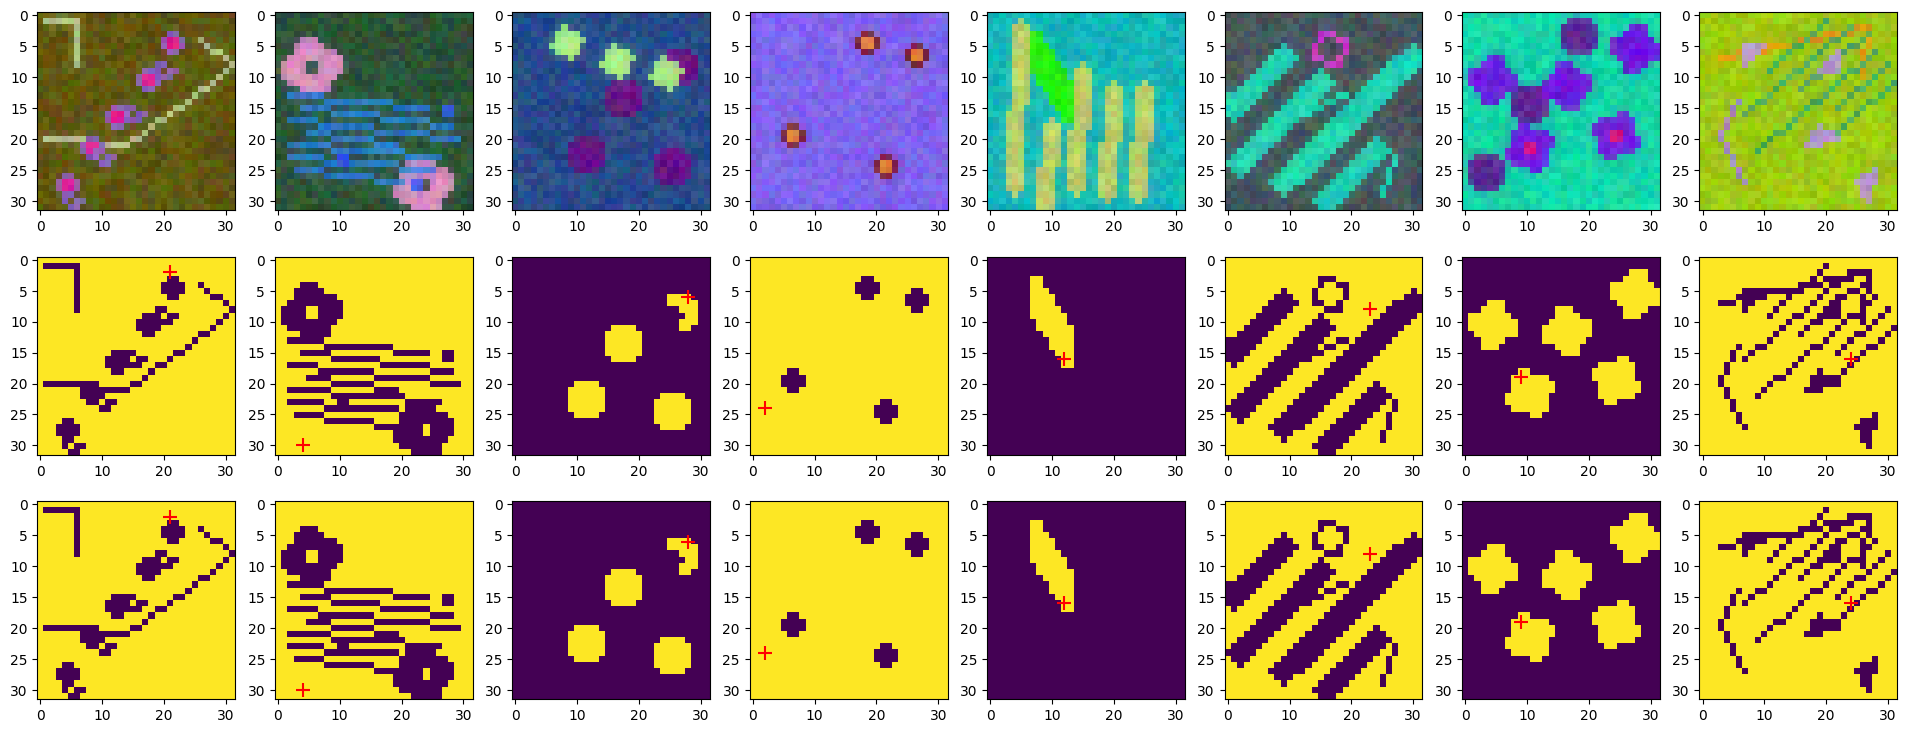

In [41]:
img, labels = next(test_iter)
s = len(img)
labels = tf.squeeze(SqueezeImg()(labels), axis=-1)
labels = tf.matmul(labels, labels, transpose_a=True)

preds = trainer.model(img, training=False)
#print(labels.shape, preds.shape)
f1_metric = WeightedF12D()(labels, preds)
print('F1:', f1_metric.numpy())

sample_points = tf.random.uniform((s,), 0, 32**2, dtype=tf.int32)
sample_labels = UnSqueezeImg()(tf.gather(labels, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])
sample_preds = UnSqueezeImg()(tf.gather(labels, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])

sample_points = decode1Dcoords(sample_points, 32)

#print(sample_labels.shape, sample_preds.shape, sample_points.shape)

fig, axs = plt.subplots(3, s, figsize=(s*3, 3*3))

for i in range(s):
    axs[0,i].imshow(img[i])

    axs[1,i].imshow(sample_labels[i], vmin=0, vmax=1)
    axs[1,i].scatter(*sample_points[i], marker='+', color='red', s=100)

    axs[2,i].imshow(sample_preds[i], vmin=0, vmax=1)
    axs[2,i].scatter(*sample_points[i], marker='+', color='red', s=100)